# Captcha Recognition Model

## Set up

In [41]:
!pip install opencv-python
!pip install numpy

In [7]:
import torch
from torch.utils.data import DataLoader,Dataset, random_split
from torch import optim
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import cv2
import numpy as np
import matplotlib as plt
import math
import random # sampling captcha text
import os # used for path and image storage
from captcha.image import ImageCaptcha  # Module that will generate all captcha images# pip install captcha
import time


In [8]:
# Set device to point to a GPU if we have one, CPU otherwise.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Data Preprocessing

In [9]:
def remove_noise(image_path, save_path):
    # Open the image using Pillow
    image = Image.open(image_path)

    # Convert the image to grayscale
    gray_image = image.convert('L')

    # Convert PIL image to numpy array
    np_image = np.array(gray_image)

    # Apply binary thresholding
    _, binary_image = cv2.threshold(np_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Apply morphological operations (optional)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=1)  # Increase iterations for more noise removal

    # Invert the binary image
    inverted_image = cv2.bitwise_not(opening)

    # Save the inverted binary image
    inverted_image_pil = Image.fromarray(inverted_image)

    # Invert the colors again to have black background and white letters
    inverted_image_pil = inverted_image_pil.convert('L')
    inverted_image = np.array(inverted_image_pil)
    inverted_image = cv2.bitwise_not(inverted_image)

    # Save the final image
    final_image = Image.fromarray(inverted_image)
    final_image.save(save_path)


In [10]:
# trying to resize the image
def resize_image(image, new_width, new_height):
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))

    # Apply binary thresholding to ensure black and white pixels only
    _, binary_image = cv2.threshold(resized_image, 127, 255, cv2.THRESH_BINARY)


    # Return the final inverted image
    return binary_image

def save_contours_as_images(image_path, output_directory, image_id):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to obtain binary image
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)
#
    ## Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours based on x-coordinate
    contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])

    # Create output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    counter = 0 # keep track of how many characters have been saved
    label = image_path.split('/')[0].split('.')[0].split("\\")[1]
    # print(label)
    image_name = label.split("--")[0]
    char_labels = [char_label for char_label in label.split("_")[0]]
    # print(char_labels)
    
    for i, contour in enumerate(contours):
        # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)

        if counter > 3:
            break

        # Check if contour is too small (possibly noise)
        if w > 5 and h > 5:
            # Add some padding around the character bounding box
            padding = 10
            x_padding = max(0, x - padding)
            y_padding = max(0, y - padding)
            w_padding = min(image.shape[1], w + 2 * padding)
            h_padding = min(image.shape[0], h + 2 * padding)

            # Create a black canvas with padded dimensions
            padded_image = np.zeros((h_padding, w_padding), dtype=np.uint8)

            # Calculate coordinates to place the character in the center
            x_offset = (w_padding - w) // 2
            y_offset = (h_padding - h) // 2

            # Copy the character region from the original image to padded image
            padded_image[y_offset:y_offset+h, x_offset:x_offset+w] = image[y:y+h, x:x+w]

            # Resize the padded image
            # Resize method is adding a smooth image.
            resized_image = resize_image(padded_image, 100, 100)

            # Save the resized image as a separate image
            character_filename = os.path.join(output_directory, f'{image_name}_{char_labels[counter]}--{image_id}.png')
            cv2.imwrite(character_filename, resized_image)
            print(f"contour saved: {character_filename}")
            counter += 1    
            image_id += 1

### Passing images to the filter (new image generation)

In [14]:
# Generate denoised images
folder = 'four_cap_36_new_2'
output_folder = 'denoised_2'

# Get list of all files in the folder
file_list = os.listdir(folder)

# Iterate through the first 10 images in the folder
for i, filename in enumerate(file_list):    
    # Check if the file is an image (you can add more image extensions if needed)
    if filename.lower().endswith(('.png')):
        # Construct the full path to the image
        image_path = os.path.join(folder, filename)
        
        # Save path for the denoised image
        # original image -> denoised image (now named after its label)
        label = filename.split('-')[0]
        save_filename = f'{label}_{i}--denoised.png'
        save_path = os.path.join(output_folder, save_filename)
        
        # Call the remove_noise function
        remove_noise(image_path, save_path)


### Cropping Characters (New Image Generation)

In [15]:
# Folder path containing the images
folder_path = 'denoised_2' # change folders for testing

# Output directory for saved contour images
output_directory = 'cropped_2' # change folders for testing

# Get list of all files in the folder
file_list = os.listdir(folder_path)

image_id = 0

# Iterate through the first 10 images in the folder
for i, filename in enumerate(file_list):
    # Check if the file is an image (you can add more image extensions if needed)
    if filename.lower().endswith(('.png')):
        # Construct the full path to the image
        image_path = os.path.join(folder_path, filename)
        
        # Call the save_contours_as_images function
        save_contours_as_images(image_path, output_directory, image_id)

        image_id += 4

contour saved: cropped_2\11A1_0_1--0.png
contour saved: cropped_2\11A1_0_1--1.png
contour saved: cropped_2\11A1_0_A--2.png
contour saved: cropped_2\11A1_0_1--3.png
contour saved: cropped_2\11CQ_1_1--4.png
contour saved: cropped_2\11CQ_1_1--5.png
contour saved: cropped_2\11CQ_1_C--6.png
contour saved: cropped_2\11CQ_1_Q--7.png
contour saved: cropped_2\11LG_2_1--8.png
contour saved: cropped_2\11LG_2_1--9.png
contour saved: cropped_2\11LG_2_L--10.png
contour saved: cropped_2\11LG_2_G--11.png
contour saved: cropped_2\125G_3_1--12.png
contour saved: cropped_2\125G_3_2--13.png
contour saved: cropped_2\125G_3_5--14.png
contour saved: cropped_2\125G_3_G--15.png
contour saved: cropped_2\12X5_4_1--16.png
contour saved: cropped_2\12X5_4_2--17.png
contour saved: cropped_2\12X5_4_X--18.png
contour saved: cropped_2\12X5_4_5--19.png
contour saved: cropped_2\13K7_5_1--20.png
contour saved: cropped_2\13K7_5_3--21.png
contour saved: cropped_2\13K7_5_K--22.png
contour saved: cropped_2\13K7_5_7--23.png
co

### Custom Class for Cropped Characters

In [10]:
classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] # 35 classes

In [5]:
class CroppedCharacterDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert image to grayscale
        
        # Extract label and image id from file name
        filename = os.path.splitext(os.path.basename(img_path))[0]

        # format: {ParentImageName}_{image_num}_{char_label}--{id}.png
        parts = filename.split('_')
        label, image_id = parts[-1].split('--')  # Split last part
        label = label.strip()  # Remove any leading/trailing whitespace
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# root directory where images are stored
root_dir = "cropped_characters"

# Define transformations if needed
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset instance
cropped_chars_dataset = CroppedCharacterDataset(root_dir, transform=transform)

26116
Train: 26116 examples into 817 batches
{'1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, 'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0, 'L': 0, 'M': 0, 'N': 0, 'O': 0, 'P': 0, 'Q': 0, 'R': 0, 'S': 0, 'T': 0, 'U': 0, 'V': 0, 'W': 0, 'X': 0, 'Y': 0, 'Z': 0}


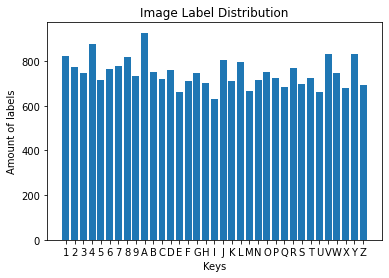

In [14]:
# Define the sizes of each split
print(len(cropped_chars_dataset)) # total number of images in dataset
train_size = int(1 * len(cropped_chars_dataset))
# dev_size = int(0.2 * len(cropped_chars_dataset))
# test_size = len(cropped_chars_dataset) - train_size - dev_size

# Split dataset into train, validation, and test sets
# train_data, dev_data, test_data = random_split(cropped_chars_dataset, [train_size, dev_size, test_size])

train_loader = torch.utils.data.DataLoader(cropped_chars_dataset, batch_size=32, shuffle=True)

# Create data loaders
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Train: {len(train_loader.dataset)} examples into {len(train_loader)} batches")
# print(f"Test: {len(test_loader.dataset)} examples into {len(test_loader)} batches")
# print(f"Test: {len(dev_loader.dataset)} examples into {len(dev_loader)} batches")

all_classes = {character : 0 for character in classes}
print(all_classes)
# print(train_loader.dataset[0])
for data in train_loader.dataset:
    image, label = data
    all_classes[label] += 1

# Extract keys and values from the dictionary
labels = list(all_classes.keys())
values = list(all_classes.values())

# Plotting the number of labels for each possible class. 
plt.bar(labels, values)
plt.xlabel('Keys')
plt.ylabel('Amount of labels')
plt.title('Image Label Distribution')
plt.show()

## `train_model(model, dataloader, epochs)`

This function should train the given model using the given data for the given number of epochs.

**Arguments**
 * `model`: A PyTorch model.  You can assume here that it has already been moved to `device` (and you should assure that is the case when calling this function).
 * `dataloader`: A PyTorch DataLoader.
 * `epochs`: The number of full epochs to train.

**Return value**
 * None.

Use `torch.nn.CrossEntropyLoss()` for the loss function and `optim.Adam` with its default hyperparameters for the optimization algorithm.

Use the `stats` object to print training statistics before, during, and after the training run (see above for instructions).

Don't forget to move all tensors to `device` so they are placed on the GPU if one is present.

In [9]:
def train_model(model, dataloader, epochs):
    # Starting stats object
    # stats.start()

    # Loss function
    criterion = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters())

    # Loop over the dataset for the given number of epochs
    for epoch in range(epochs):
        # Iterate over the batches of data
        for inputs, labels in dataloader:
            # Move inputs and labels to GPU if possible
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Get outputs from forward propagation
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward propagation
            loss.backward()

            # Perform a single optimization step (parameter update)
            optimizer.step()

# Model

In [32]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=35):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        # self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 12 * 12)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

In [33]:
def train_model(model, train_loader, num_epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            # images, labels = batch[0], batch[1]  # Unpack the batch tuple and move tensors to the configured device
            images = images.to(device)
            # Extract and convert labels to integers
            label_strings = [label_tuple[0] for label_tuple in labels]
            label_indices = [label_strings.index(label) for label in label_strings]
            labels = torch.tensor(label_indices, dtype=torch.long).to(device)
            
            # zero the gradients
            optimizer.zero_grad()

            # forward propagation
            outputs = model(images)

            # computer loss
            loss = criterion(outputs, labels)
            
            # backward prop
            loss.backward()

            # update
            optimizer.step()
            
            # calculating stats
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item() * images.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%")

In [34]:
# Get ResNet18 model with randomized weights
model = CNNModel()

epochs = 10

learning_rate = 0.1

# Move the model to GPU if not already in there
train_model(model, train_loader, epochs, learning_rate)

# Check accuacy without training
# overall_accuracy, class_accuracy = test_model(model, test_loader)
# print(f'Accuracy before training: {overall_accuracy}')
# 
# # Train the model for 3 epochs
# train_model(model, train_loader, 5)
# 
# # Checki accuracy after training
# accuracy_after_training, class_accuracies_after_training = test_model(model, test_loader)
# print(f'Accuracy after training: {accuracy_after_training}')

KeyboardInterrupt: 